# Description

This notebook uses the median- and quantile-derived scale factors ($\beta$ values, outputs from [MedianScaling_calculate_beta.ipynb](./MedianScaling_calculate_beta.ipynb) and [QuantileScaling_calculate_beta.ipynb](./QuantileScaling_calculate_beta.ipynb), respectively) to scale the climatological distribution (CLIM) of maximum temperatures (defined as the collection of observations over 1985-2015) at each location globally and for each month of the year.

The resulting forced and counterfactual distributions of maximum temperatures are used in the the observation-based attribution analysis. Example attributuon analyses with these output distributions at Phoenix, AZ, USA, are provided in XXXXXXXX.

---


The idea is to create a table of outputs which describe the number of Natural counts one would expect to see over three different time scales---annual, seasonal (3 months), and monthly---given a particularly chosen percentile.

Time scales:
* Annual (1 year: 365 days)
* Seasonal (3 months: DJF, MAM, JJA, SON; ndays vary by months included)
* Monthly (ndays vary by month)

Percentiles explored:
* 99.99, 99.9, 99, 98, 97.5, 97, 96, ..., 50
* 0.01, 0.1, 1, 2, 2.5, 3, 4, 5, ..., 49

In [ ]:
import numpy as np
import pandas as pd
from calendar import monthrange
import matplotlib.pyplot as plt
import xarray as xr
import os

### Definitions -- Percentiles and Time Periods

In [2]:
# define the percentile grids
midgrid=np.arange(3,96+1,1)
lowgrid=np.asarray([0.01,0.1,1,2,2.5])
highgrid=np.flip(100-lowgrid)
# combine them into a single grid
pgrid=np.concatenate((lowgrid,midgrid,highgrid))
npc=len(pgrid)

In [3]:
# define the number of days in each month (ignore leap years)
mondays=np.asarray([monthrange(2011, i)[1] for i in np.arange(12)+1])
# get the number of days in a year
ndays_yr=np.sum(mondays)
# get the number of days in each season (DJF, MAM, JJA, SON), by shifting mondays 1 month
ndays_seas=np.asarray([np.sum(np.roll(mondays,1)[i:i+3]) for i in np.arange(0,10,3)])

## Find the number of Natural counts

The number of natural counts for a specific period is by the definition of the percentile, where the ordinal rank ($n_{rank}$) is given by the percentile between 0 and 100, $p$, and the number of values in the ordered list ($N$):

$ n_{rank} = \frac{p}{100} \times N$

For our purposes, the number of values in our list corresponds to the number of days we are analyzing over, i.e. $N \equiv n_{days}$:

$ n_{rank,day} = \frac{p}{100} \times (n_{days})$

So that, through the definition of the ordinal rank, the total of number of days which will exceed it ($n_{exceedances}$), based on the percentile, is given by:

$n_{exceedances} = n_{days} - n_{rank,day} = n_{days} - \frac{p}{100} \times (n_{days}) $

#### Example

Let's assume that we are searching for the threshold for the number of exceedances of the defined percentile threshold, if $p=95$ and our time period is annual ($n_{days}=365$).

#### Subceedance

If we are looking for the number of values _under_ the threshold, we would find the subceedance, which is equal to the number of days in our period MINUS the threshold number, i.e. 
$n_{subceedances} =  n_{days} - n_{exceedances}$ , which is identically $n_{rank,day}$.

NOTE: The unit of $n_{exceedances}$/$n_{subceedances}$ always matches that of the counts in your list (annual is number of days)

In [4]:
# Function to calculate the natural threshold associated with a list of values
def nat_exceed(pp,ndays):
    # pp is the percentile over 0-100
    # ndays in the number of values in your list (usually number of days)
    nexceed=ndays-(pp/100)*ndays
    return(nexceed)

def nat_subceed(pp,ndays):
    # pp is the percentile over 0-100
    # ndays in the number of values in your list (usually number of days)
    nsubceed=(pp/100)*ndays
    return(nsubceed)

In [5]:
p1=95
n1=nat_exceed(p1,ndays_yr)
n2=nat_subceed(p1,ndays_yr)
print(n1)
print(n2)

18.25
346.75


So all together, for the 95th percentile we would expect there to be exactly 18.25 days which would meet or exceed this percentile over a representative 365 day period. Meanwhile, the number of days at or below that threshold is 346.75.

## Create the Grids

In [6]:
# create an annual grid of exceedances
annual_exceed=np.empty((npc,),dtype='float')
annual_exceed[:,]=nat_exceed(pgrid,ndays_yr)
annual_subceed=np.empty((npc,),dtype='float')
annual_subceed[:,]=nat_subceed(pgrid,ndays_yr)

# create a monthly and seasonal grid
mon_exceed=np.empty((npc,len(mondays)),dtype='float')
mon_subceed=np.empty((npc,len(mondays)),dtype='float')
seas_exceed=np.empty((npc,len(ndays_seas)),dtype='float')
seas_subceed=np.empty((npc,len(ndays_seas)),dtype='float')
for pp,p0 in enumerate(pgrid):
    seas_exceed[pp,:]=nat_exceed(p0,ndays_seas)
    mon_exceed[pp,:]=nat_exceed(p0,mondays)
    seas_subceed[pp,:]=nat_subceed(p0,ndays_seas)
    mon_subceed[pp,:]=nat_subceed(p0,mondays)

In [7]:
np.mean(ndays_seas)

91.25

In [8]:
# print(pgrid[92],pgrid[97],pgrid[99],pgrid[101])
print(pgrid[92])
print(np.mean(mondays))
print(np.mean(mon_exceed[92,:]))

print(pgrid[97])
print(np.mean(mon_exceed[97,:]))

print(pgrid[99])
print(np.mean(mon_exceed[99,:]))

print(pgrid[101])
print(np.mean(mon_exceed[101,:]))

90.0
30.416666666666668
3.0416666666666656
95.0
1.520833333333334
97.5
0.7604166666666679
99.0
0.30416666666666625


In [45]:
print(pgrid[92])
print(np.mean(ndays_seas))
print(np.mean(seas_exceed[92,:]))

print(pgrid[97])
print(np.mean(seas_exceed[97,:]))

print(pgrid[99])
print(np.mean(seas_exceed[99,:]))

print(pgrid[101])
print(np.mean(seas_exceed[101,:]))

90.0
91.25
9.125
95.0
4.5625000000000036
97.5
2.28125
99.0
0.9125000000000014


In [49]:
print(pgrid[92])
print(np.mean(365))
print(np.mean(annual_exceed[92]))

print(pgrid[97])
print(np.mean(annual_exceed[97]))

print(pgrid[99])
print(np.mean(annual_exceed[99]))

print(pgrid[101])
print(np.mean(annual_exceed[101]))

90.0
365.0
36.5
95.0
18.25
97.5
9.125
99.0
3.6499999999999773


In [48]:
annual_exceed

array([3.649635e+02, 3.646350e+02, 3.613500e+02, 3.577000e+02,
       3.558750e+02, 3.540500e+02, 3.504000e+02, 3.467500e+02,
       3.431000e+02, 3.394500e+02, 3.358000e+02, 3.321500e+02,
       3.285000e+02, 3.248500e+02, 3.212000e+02, 3.175500e+02,
       3.139000e+02, 3.102500e+02, 3.066000e+02, 3.029500e+02,
       2.993000e+02, 2.956500e+02, 2.920000e+02, 2.883500e+02,
       2.847000e+02, 2.810500e+02, 2.774000e+02, 2.737500e+02,
       2.701000e+02, 2.664500e+02, 2.628000e+02, 2.591500e+02,
       2.555000e+02, 2.518500e+02, 2.482000e+02, 2.445500e+02,
       2.409000e+02, 2.372500e+02, 2.336000e+02, 2.299500e+02,
       2.263000e+02, 2.226500e+02, 2.190000e+02, 2.153500e+02,
       2.117000e+02, 2.080500e+02, 2.044000e+02, 2.007500e+02,
       1.971000e+02, 1.934500e+02, 1.898000e+02, 1.861500e+02,
       1.825000e+02, 1.788500e+02, 1.752000e+02, 1.715500e+02,
       1.679000e+02, 1.642500e+02, 1.606000e+02, 1.569500e+02,
       1.533000e+02, 1.496500e+02, 1.460000e+02, 1.4235

## Plot the results

### Annual

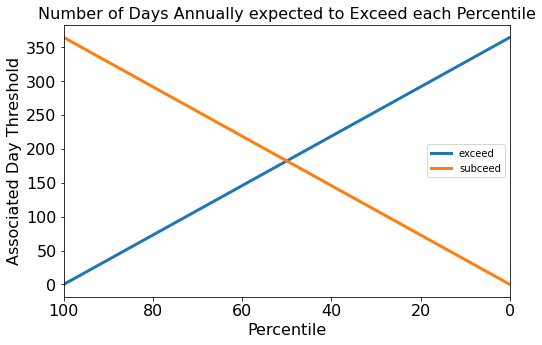

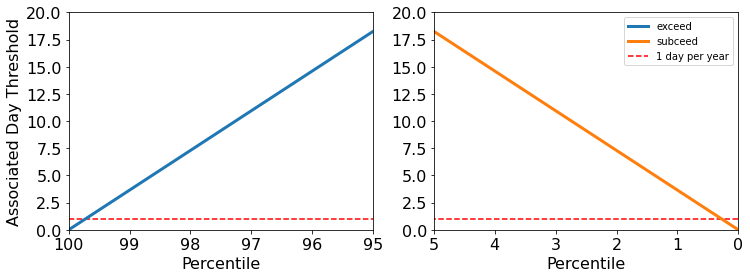

In [7]:
plt.figure(figsize=(8,5))
plt.plot(pgrid,annual_exceed,lw=3,label='exceed')
plt.plot(pgrid,annual_subceed,lw=3,label='subceed')
plt.xlim([100,0])
plt.xlabel('Percentile',fontsize=16)
plt.ylabel('Associated Day Threshold',fontsize=16)
plt.title('Number of Days Annually expected to Exceed each Percentile',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(pgrid,annual_exceed,lw=3,label='exceed')
plt.plot(pgrid,annual_subceed,lw=3,label='subceed')
plt.xlim([100,95])
plt.ylim([0,20])
plt.xlabel('Percentile',fontsize=16)
plt.ylabel('Associated Day Threshold',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hlines(1,0,100,color='r',linestyle='--')

plt.subplot(1,2,2)
plt.plot(pgrid,annual_exceed,lw=3,label='exceed')
plt.plot(pgrid,annual_subceed,lw=3,label='subceed')
plt.xlim([5,0])
plt.ylim([0,20])
plt.xlabel('Percentile',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hlines(1,0,100,color='r',linestyle='--',label='1 day per year')

plt.legend()
plt.show()

### Seasonal

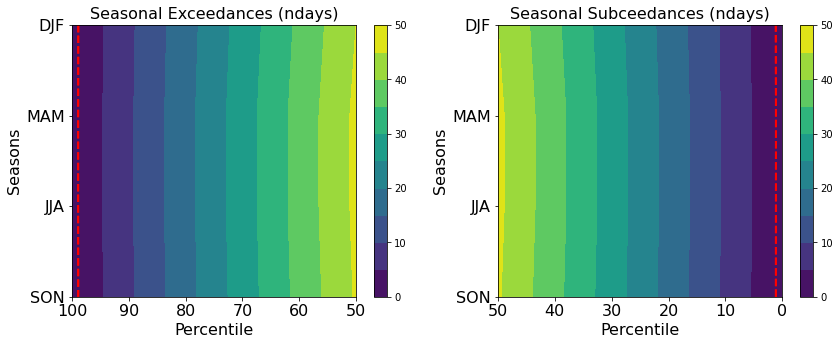

In [8]:
plt.figure(figsize=(14,5))
clevels=np.arange(0,55,5)
seaslabels=['DJF','MAM','JJA','SON']

plt.subplot(1,2,1)
c1=plt.contourf(pgrid,np.arange(4),seas_exceed.T,levels=clevels)
plt.contour(pgrid,np.arange(4),seas_exceed.T,colors='r',linewidths=2,linestyles='--',levels=[0.99,1.01])
plt.yticks(np.arange(4),seaslabels)
plt.colorbar(c1)
plt.xlim([100,50])
plt.ylim([3,0])
plt.xlabel('Percentile',fontsize=16)
plt.ylabel('Seasons',fontsize=16)
plt.title('Seasonal Exceedances (ndays)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1,2,2)
c2=plt.contourf(pgrid,np.arange(4),seas_subceed.T,levels=clevels)
plt.contour(pgrid,np.arange(4),seas_subceed.T,colors='r',linewidths=2,linestyles='--',levels=[0.99,1.01])
plt.yticks(np.arange(4),seaslabels)
plt.colorbar(c2)
plt.xlim([50,0])
plt.ylim([3,0])
plt.xlabel('Percentile',fontsize=16)
plt.ylabel('Seasons',fontsize=16)
plt.title('Seasonal Subceedances (ndays)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Monthly

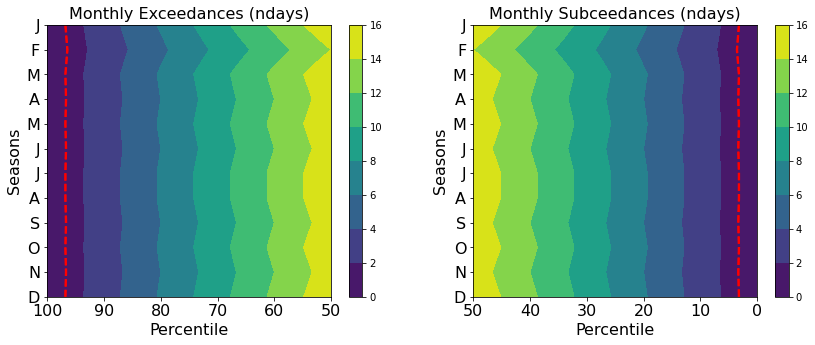

In [9]:
plt.figure(figsize=(14,5))
clevels=np.arange(0,16+1,2)
monlabels=['J','F','M','A','M','J','J','A','S','O','N','D']

plt.subplot(1,2,1)
c1=plt.contourf(pgrid,np.arange(12),mon_exceed.T,levels=clevels)
plt.contour(pgrid,np.arange(12),mon_exceed.T,colors='r',linewidths=2,linestyles='--',levels=[0.99,1.01])
plt.yticks(np.arange(12),monlabels)
plt.colorbar(c1)
plt.xlim([100,50])
plt.ylim([11,0])
plt.xlabel('Percentile',fontsize=16)
plt.ylabel('Seasons',fontsize=16)
plt.title('Monthly Exceedances (ndays)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1,2,2)
c2=plt.contourf(pgrid,np.arange(12),mon_subceed.T,levels=clevels)
plt.contour(pgrid,np.arange(12),mon_subceed.T,colors='r',linewidths=2,linestyles='--',levels=[0.99,1.01])
plt.yticks(np.arange(12),monlabels)
plt.colorbar(c2)
plt.xlim([50,0])
plt.ylim([11,0])
plt.xlabel('Percentile',fontsize=16)
plt.ylabel('Seasons',fontsize=16)
plt.title('Monthly Subceedances (ndays)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

## Save out the results

We will create the result in an xarray dataset and then save out the result into a netcdf

In [10]:
dso=xr.Dataset(
    {
        'AnnualExceedance': (['pp'], annual_exceed),
        'AnnualSubceedance': (['pp'], annual_subceed),
        'SeasonalExceedance': (['pp','seas'], seas_exceed),
        'SeasonalSubceedance': (['pp','seas'], seas_subceed),
        'MonthlyExceedance': (['pp','mon'], mon_exceed),
        'MonthlySubceedance': (['pp','mon'], mon_subceed),
    },
    coords={
        'pp': (['pp'], pgrid.squeeze()),
        'seas': (['seas'], seaslabels),
        'mon': (['mon'], monlabels)
    },
    attrs={
        'Dataset Unit': 'Number of Days Equal to or Exceeding OR Subceeding the percentile'
    }
)

In [20]:
# save out the result
savepath='/home/dgilford/fingerprints/data/metadata/'
savename='Ndays_Exceedance.nc'
# remove the file if it already exists
if os.path.exists(savepath+savename):
    os.remove(savepath+savename)
# the save the result
dso.to_netcdf('/home/dgilford/fingerprints/data/metadata/Ndays_Exceedance.nc')